# LSST Camera Sensor Annomalies: Figures

Author: Johnny Esteves, University Of Michigan


The figure 1 is deviation maps with flux, position, psf-size, shape.

In [1]:
cd ..

/Users/jesteves/Documents/GitHub/lsst-treeRing


In [2]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
plt.rc('image', interpolation='bicubic', origin='lower', cmap = 'viridis')
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams['figure.figsize'] = [14.0, 10.0]
plt.rcParams['font.size'] = 16
rcParams = plt.rcParams.copy()

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [3]:
def saveFig(fig, fname, dpi=120):
    fig.savefig(fname, dpi=dpi, format='pdf', bbox_inches='tight')

## Load Data

Retrieve the output measurements from the spotgrid detector code, ```mixcoatl```.


In [4]:
from matplotlib.backends.backend_pdf import PdfPages
from helper_plot_figures import make_plot_figure1, load_figure_dict

# tmp_file = 'Figure_march4th'
tmp_file = 'figure_march5th'
figure1 = load_figure_dict(tmp_file)

You are not connected to a LSST machine
Fake Bluter


In [5]:
# !rm ./tmp/Figure_march5th.pkl

### Mixcoatl output

<b> Updates since raft9 data </b>:

<li> correction for shaking on the z-direction of the xy-motor plataform </li>
<li> new distortion map imaging functionality </li>    
<li> compute ellipticities based on the second moments with eqn 23 from Schneider 2005 </li>
<li> transform the vectors to tree ring coordinates </li>

The respective functions are: <br>
```sensor.correct_shaking()``` <br>
```sensor.get_imaging_map()``` <br>
```sensor.compute_ellipticities2()``` <br>
```sensor.transform_to_treeRing_coords()``` <br>


## Distortion Maps

In [6]:
import datetime
from matplotlib.backends.backend_pdf import PdfPages

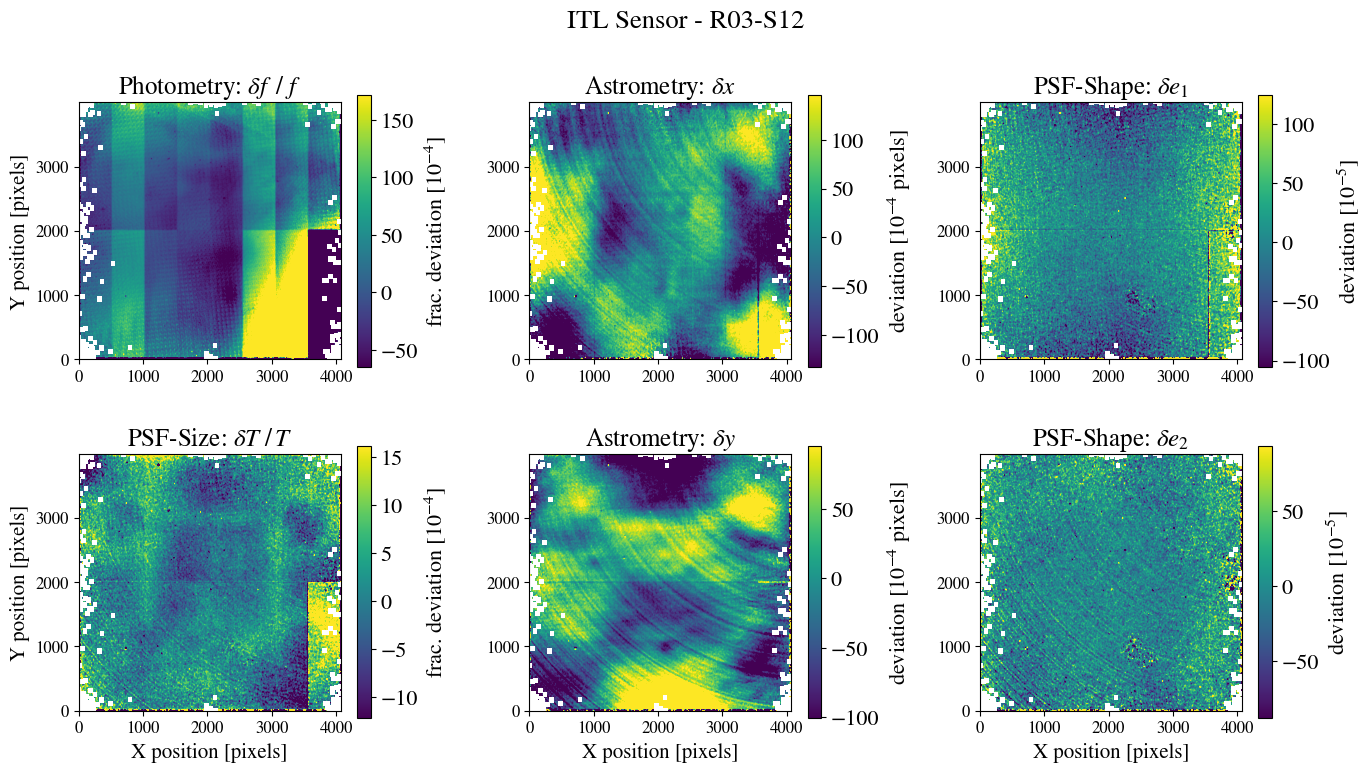

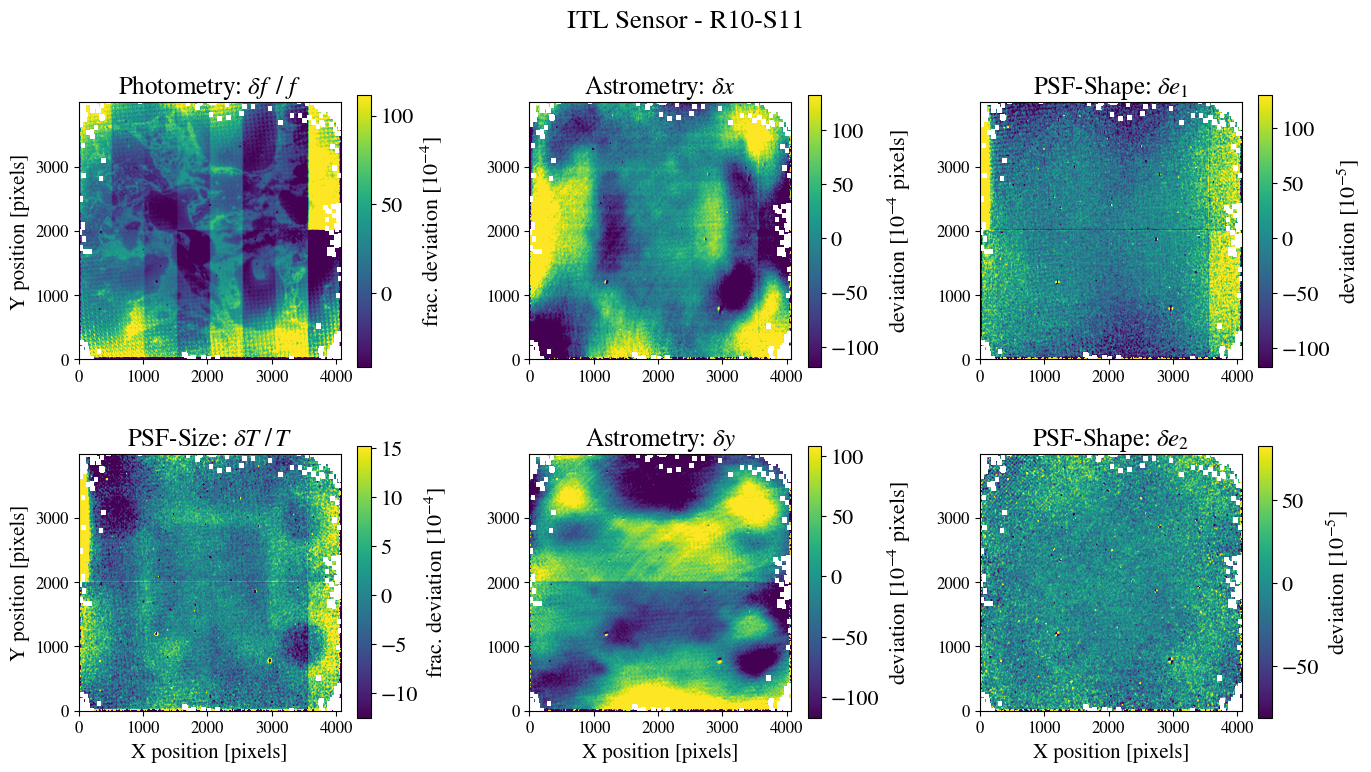

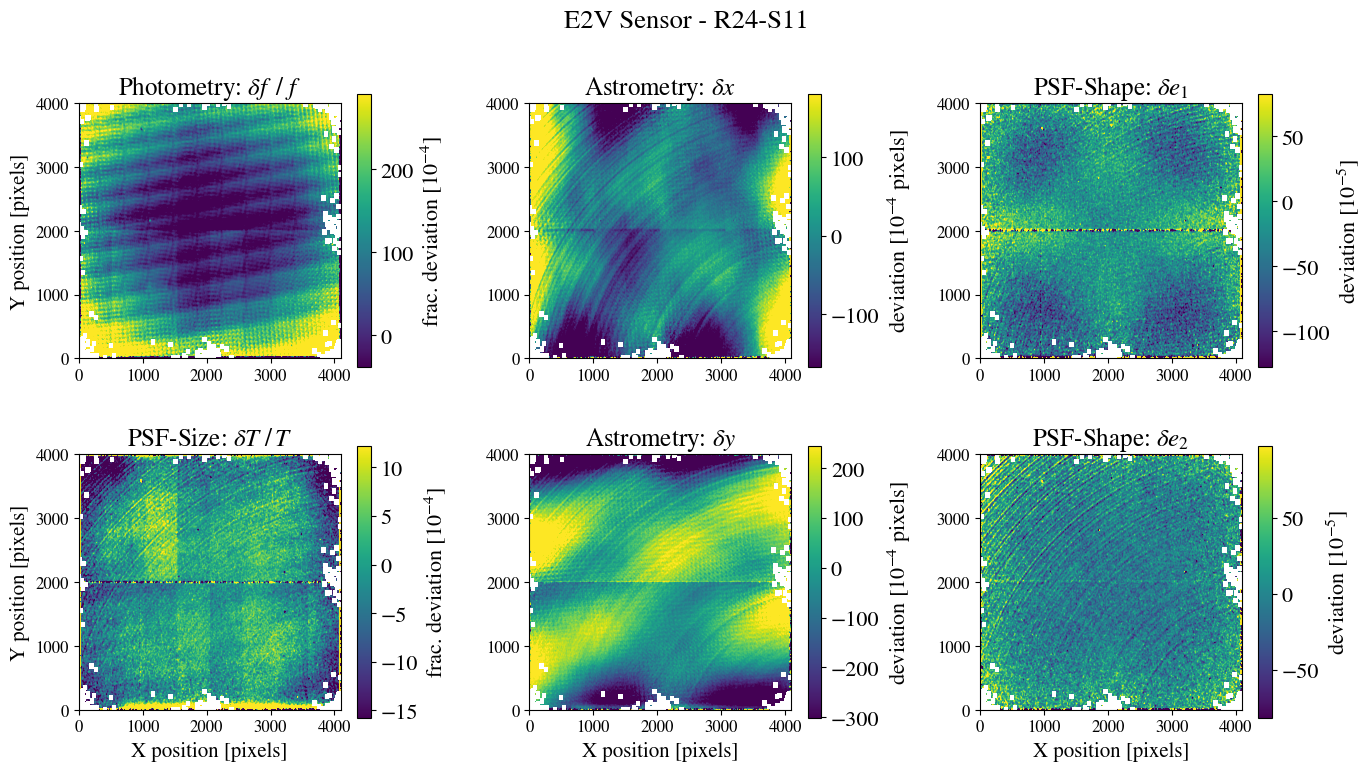

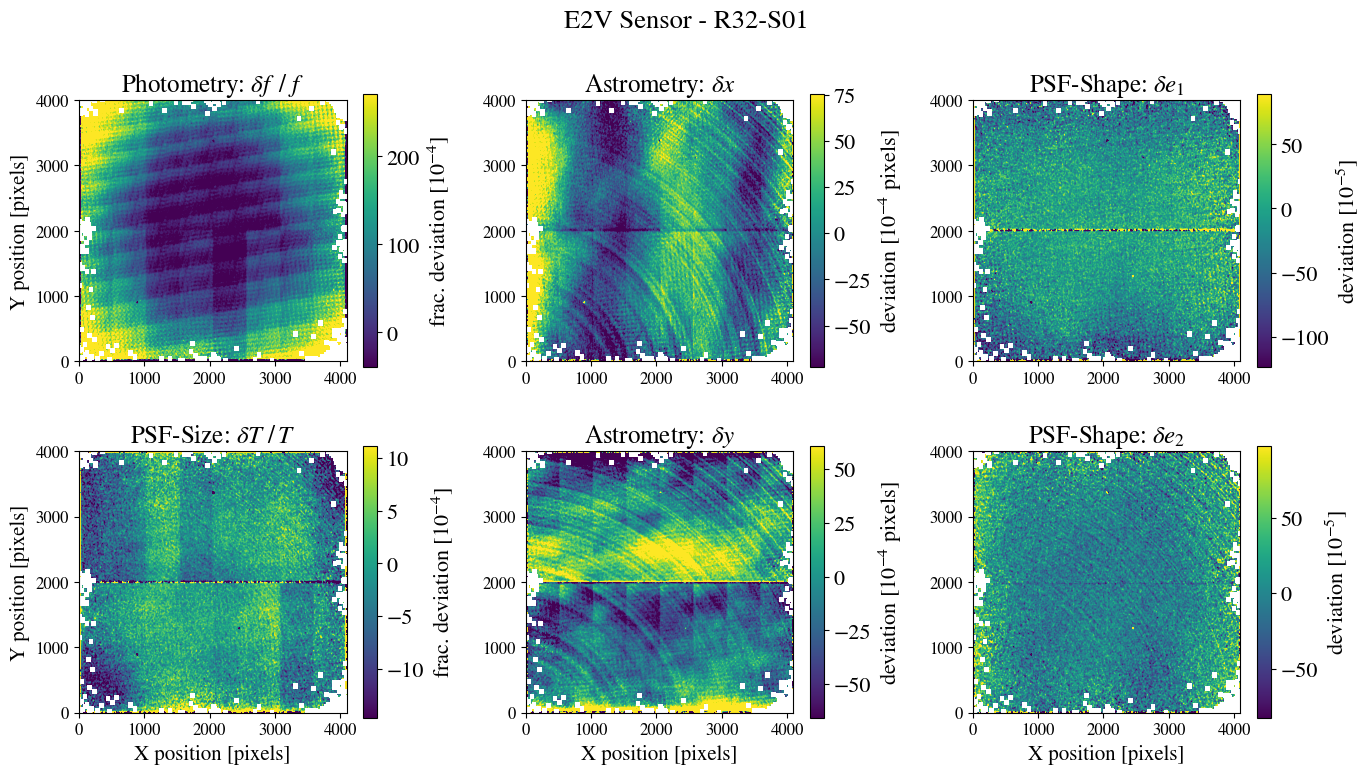

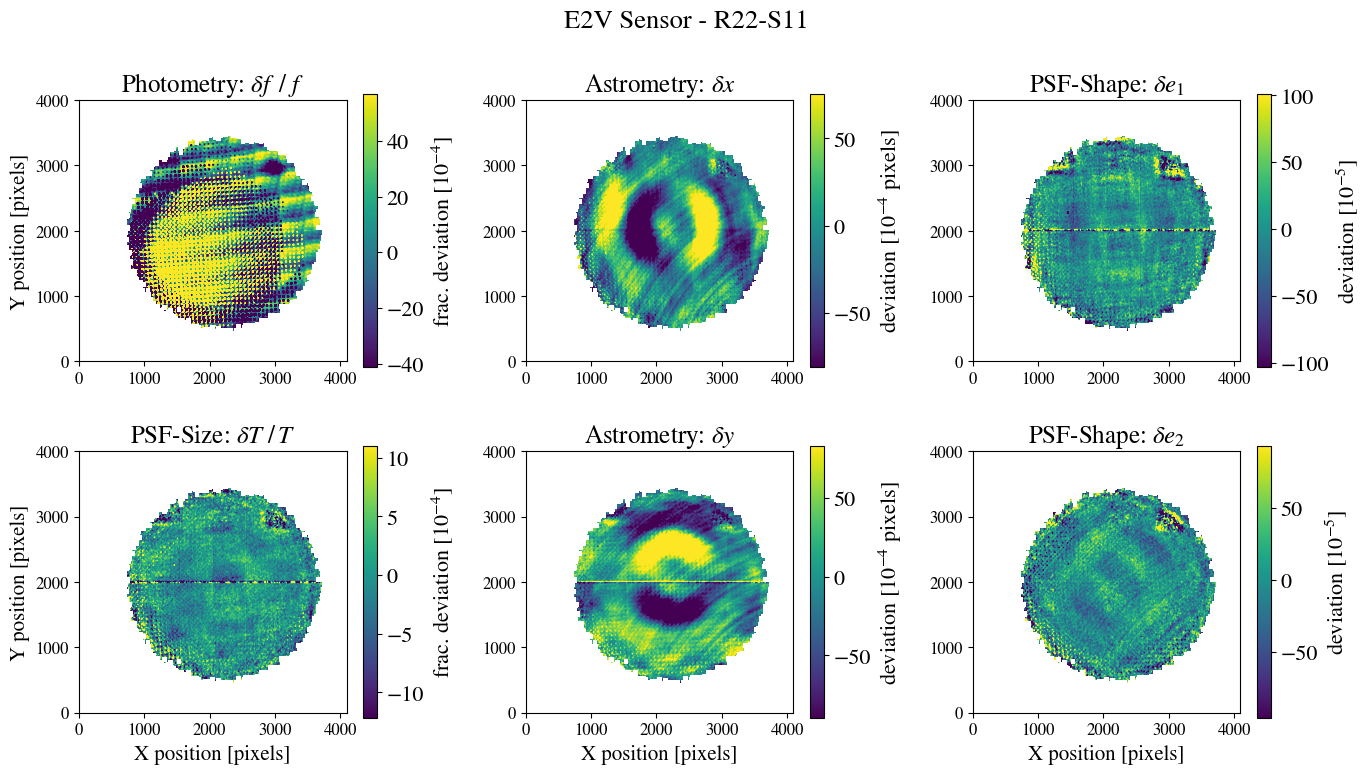

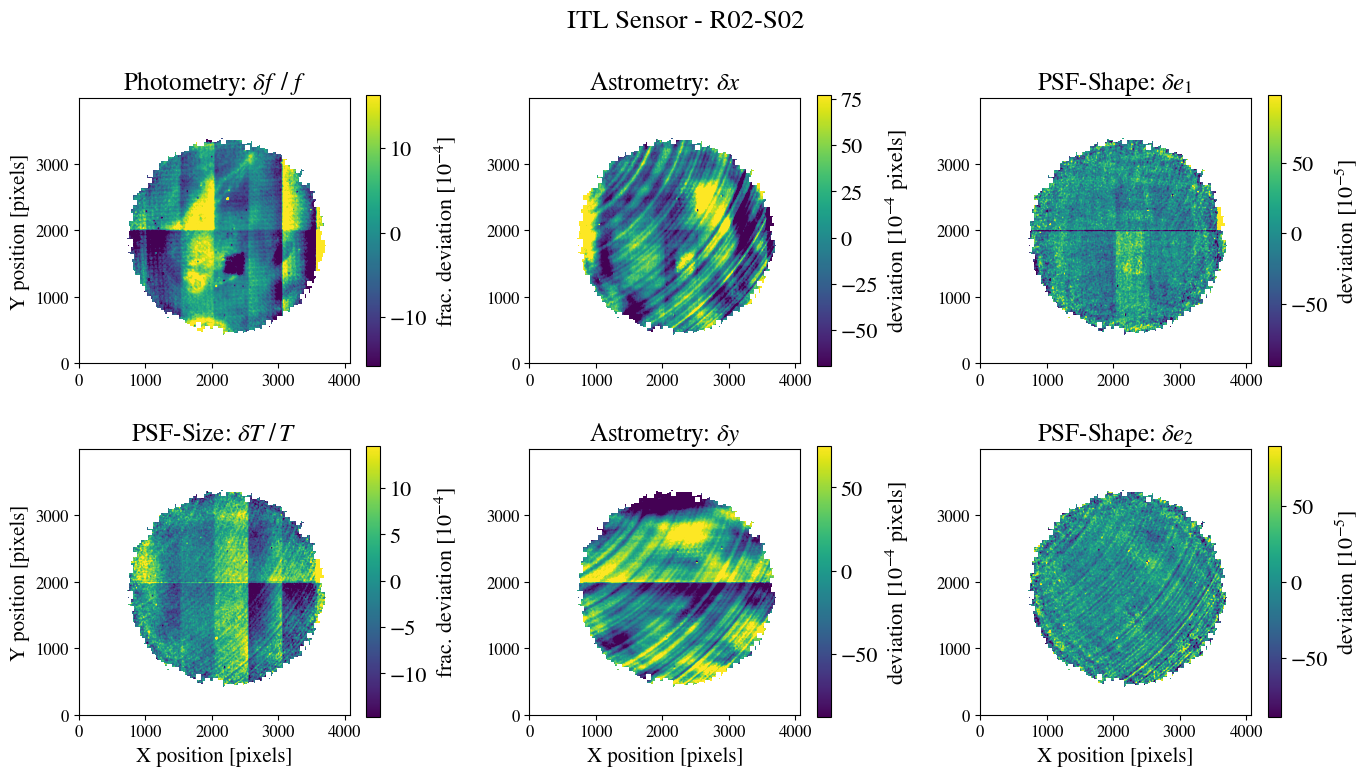

In [7]:
## plot square
with PdfPages('./figures/Figure1.pdf') as pdf:
    for ix in range(len(figure1['flux'])):
        make_plot_figure1(figure1, ix)
        pdf.savefig()
        
# saveFig(fig, './figures/Figure1')

I choose two figures as an example for each sensor.

In [8]:
# fig = make_plot_figure1(0)
# saveFig(fig, './figures/Figure1_a.pdf')

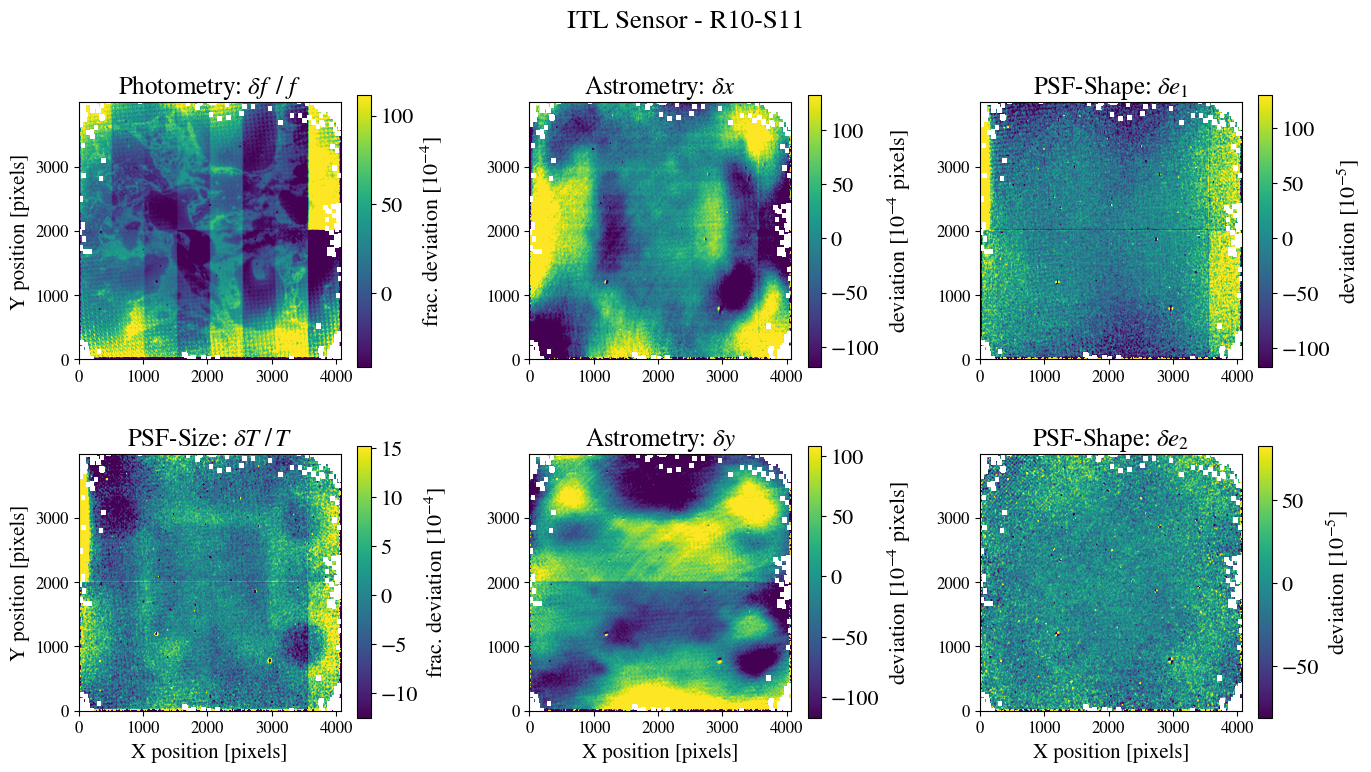

In [9]:
fig = make_plot_figure1(figure1, 1)
saveFig(fig, './figures/Figure1_b.pdf')

In [10]:
# plt.hist(figure1['flux'][0].img)

# Outdated

In [11]:
import tree_ring_helper as tr
keys1 = {
        'flux':['abs','Flux-Ratio','perc. deviation [\%]', 100.],
        'psf-size':['abs','PSF-Size: $\delta T = \delta I_{xx}+ \delta I_{yy}$','perc. deviation [\%]',100.],
        'pos-x':['x','Position: $\delta x$','[pixels]',1.],
        'pos-y':['y','Position: $\delta y$','[pixels]',1.],
        'shape-x':['x','Shape: $\delta e_2$','perc. deviation [\%]',100.],
        'shape-y':['y','Shape: $\delta e_1$','perc. deviation [\%]',100.],
       }

def component_map(shortcut):
    res = {
           'flux':'flux-ratio','psf-size':'psf-size',
           'pos-x':'astrometric-shift','pos-y':'astrometric-shift',
           'shape-x':'ellipticity','shape-y':'ellipticity',
          }
    return res[shortcut]

In [12]:
import os

tmp_file = './tmp/Figure_march4th.pkl'
is_local_file = os.path.isfile(tmp_file)

In [ ]:
import pickle
if is_local_file:
    figure1 = pickle.load(open(tmp_file, "rb"))
    print('Local file loaded succsefuly: %s' % tmp_file)
    print('Please skip the load section')
else:
    print('Local file not found: %s' % tmp_file)
    print('Run the following 1.2 section, it might take some time')

### Run Only Once

In [ ]:
from spotgrid_butler_new import SpotgridCatalog

repo25 = '/sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/butler.yaml'
repo9 = '/sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/butler.yaml'

setting = [
    (repo25, 'u/snyder18/spot_13242/gridfit_run1', 'u/snyder18/spot_13242/gridcalibration'),
    (repo25, 'u/snyder18/spot_13243/gridfit_run1', 'u/snyder18/spot_13243/gridcalibration'),
    (repo25, 'u/snyder18/spot_13237/gridfit_run1', 'u/snyder18/spot_13237/gridcalibration'),
    (repo25, 'u/snyder18/spot_13246/gridfit_run1', 'u/snyder18/spot_13246/gridcalibration'),
    (repo9, 'u/asnyder/spot/e2v_analysis', 'u/asnyder/spot/e2v_calibration'),        
    (repo9, 'u/asnyder/spot/itl_analysis', 'u/asnyder/spot/itl_calibration')]


In [ ]:
# if not is_local_file:
# sensors
sensors = []
for mysetting in setting[:1]:
    sensor = SpotgridCatalog(*mysetting)

    #asensor.get_calibration_table()
    sensor.load_data()
    sensor.correct_shaking()
    sensor.compute_statistics()
    sensor.filter_spots(value=.4)   # value=.4
    sensor.compute_spotgrid()
    sensor.calibrate()

    # new functions
    sensor.compute_ellipticities2()
    sensor.get_imaging_map()    
    sensor.transform_to_treeRing_coords()

    sensors.append(sensor)

In [ ]:
_ = plt.hist(sensor.dg2.flatten(),np.linspace(-0.1,0.1,31))

In [ ]:
# # IT MAY TAKE SOME TIME TO RUN THIS CELL
if not is_local_file:
    ### Create Images
    figure1 = {}

    for variable in keys1.keys():
        print('Variable: %s'%variable)
        component = keys1[variable][0]
        ylabel = keys1[variable][1]
        strech = keys1[variable][3]
        rings = []

        for sensor in sensors:
            print('Sensor Bay: %s'%(sensor.sensorbay))
            ring = tr.tree_ring_tools(sensor)
            ring.make_image(component_map(variable), component, fradius=None)

            ring.apply_strech(strech)
            ring.img = ring._resize(ring.img)
            ring.apply_high_freq_filter(use_zero=False)
            ring.apply_gaussian_filter(downscale=4)
            ring.apply_mask()

            #ring.make_polar_transformation(theta_cut=[100, 250])
            #ring.compute_signal()
            #ring.make_profile(ring.diff2,step=1)
            #ring.save_profile(variable)
            rings.append(ring)
            print('\n')
        figure1[variable] = rings

In [ ]:
## save locally
if not is_local_file:
    pickle.dump(figure1, open(tmp_file, "wb"))  # save it into a file named save.p    
    print('File saved locally: %s'%tmp_file)
    

If the correction_shaking function is not applied the results are not correct.
